In [1]:
import pandas as pd
import os
import pickle

import networkx as nx

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from src.dataset.dataset_info import datasets
from src.graph.graph_measures import calculate_graph_measures
from src.graph.graph_construction.window_graph import create_weightless_window_graph
from src.graph.graph_construction.session_graph import define_sessions, create_weightless_session_graph

In [2]:
flow_graph = False

session_graph = True

window_graph = False
window_size= 2000

multi_graph=True
line_graph = False
sort_timestamp = True

In [3]:
name = "cic_ids_2017_5_percent"
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
# name = "cic_ids_2017"
# name = "cic_bot_iot"
# name = "nf_bot_iot"
# name = "edge_iiot"
# name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"

dataset = datasets[name]

In [4]:
df = pd.read_parquet(dataset.path)

In [5]:
df.head()

,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,Attack,Class
index,,,,,,,,,,,,,,,,,,,,,
66292,192.168.10.1-192.168.10.3-53-60671-17,192.168.10.3,60671.0,192.168.10.1,53.0,17.0,03/07/2017 10:23:37,30919.0,1.0,1.0,...,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,0,BENIGN,0
420414,192.168.10.8-52.84.64.212-51938-443-6,52.84.64.212,443.0,192.168.10.8,51938.0,6.0,03/07/2017 11:20:18,3.0,1.0,1.0,...,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,0,BENIGN,0
393869,172.217.10.2-192.168.10.8-80-55154-6,192.168.10.8,55154.0,172.217.10.2,80.0,6.0,5/7/2017 1:53,115525809.0,16.0,14.0,...,140027.3781,501173.0,36578.0,9976579.636,58066.24315,9994305.0,9801504.0,0,BENIGN,0
319307,192.168.10.1-192.168.10.3-53-61248-17,192.168.10.3,61248.0,192.168.10.1,53.0,17.0,03/07/2017 04:15:49,60594.0,1.0,1.0,...,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,0,BENIGN,0
419002,192.168.10.3-192.168.10.12-53-32968-17,192.168.10.12,32968.0,192.168.10.3,53.0,17.0,03/07/2017 09:40:12,310.0,2.0,2.0,...,0.0000,0.0,0.0,0.000,0.00000,0.0,0.0,0,BENIGN,0


In [6]:
cols_to_norm = list(set(list(df.columns ))  - set(list([dataset.label_col]))  - set(list([dataset.class_num_col])) - set(dataset.drop_columns)  - set(dataset.weak_columns))
cols_to_norm

['Bwd Header Len',
 'Down/Up Ratio',
 'Subflow Fwd Byts',
 'Bwd IAT Max',
 'ECE Flag Cnt',
 'SYN Flag Cnt',
 'URG Flag Cnt',
 'Fwd Header Len',
 'Active Min',
 'CWE Flag Count',
 'Flow Byts/s',
 'Bwd IAT Min',
 'Pkt Len Min',
 'Active Max',
 'Fwd Act Data Pkts',
 'Idle Min',
 'Flow IAT Min',
 'ACK Flag Cnt',
 'Fwd Pkt Len Min',
 'Fwd Seg Size Avg',
 'Init Fwd Win Byts',
 'Bwd Pkts/s',
 'Bwd Seg Size Avg',
 'Bwd IAT Tot',
 'Fwd Pkts/s',
 'Init Bwd Win Byts',
 'FIN Flag Cnt',
 'Bwd Pkt Len Min',
 'Idle Std',
 'PSH Flag Cnt',
 'Fwd Seg Size Min']

In [7]:
df[dataset.label_col].value_counts()

Label
0    113501
1     27754
Name: count, dtype: int64

In [8]:
if sort_timestamp:
    df[dataset.timestamp_col] = pd.to_datetime(df[dataset.timestamp_col].str.strip(), format=dataset.timestamp_format)
    df.sort_values(dataset.timestamp_col, inplace=True)

In [9]:
if window_graph and line_graph:
    
    df.reset_index(drop=True, inplace=True)
    df.reset_index(drop=False, inplace=True)
    
    scaler = StandardScaler()

    df[cols_to_norm] = scaler.fit_transform(df[cols_to_norm])
    df['h'] = df[ cols_to_norm ].values.tolist()
    
    folder_path="datasets/" + name + "/line_graph_unsorted"
    if sort_timestamp:
        folder_path="datasets/" + name + "/line_graph_sorted"
        
    # Ensure the folder path exists
    os.makedirs(folder_path, exist_ok=True)
    
    create_weightless_window_graph(
        df=df,
        src_ip_col=dataset.src_ip_col,
        dst_ip_col=dataset.dst_ip_col,
        window_size=window_size,
        line_graph=True,
        folder_path=folder_path,
        # folder_path=None,
        # test_percentage = 20,
        edge_attr= ['h',dataset.label_col, "index"],
        file_type="pkl")    

In [10]:
if session_graph:
    
    df.reset_index(drop=True, inplace=True)
    df.reset_index(drop=False, inplace=True)
    
    scaler = StandardScaler()

    df[cols_to_norm] = scaler.fit_transform(df[cols_to_norm])
    df['h'] = df[ cols_to_norm ].values.tolist()
    
    folder_path = "datasets/" + name + "/session_graphs"

    # Ensure the folder path exists
    os.makedirs(folder_path, exist_ok=True)
    os.makedirs(os.path.join(folder_path, 'graphs'), exist_ok=True)
    os.makedirs(os.path.join(folder_path, 'graph_measures'), exist_ok=True)

    df2 = define_sessions(df,
                          timestamp_col=dataset.timestamp_col,
                          src_ip_col=dataset.src_ip_col,
                          src_port_col=dataset.src_port_col,
                          dst_ip_col=dataset.dst_ip_col,
                          dst_port_col=dataset.dst_port_col,
                          timeout=None
                          #   protocol_col=dataset.
                          )

    graphs = create_weightless_session_graph(df2,
                                    src_ip_col=dataset.src_ip_col,
                                    dst_ip_col=dataset.dst_ip_col,
                                    multi_graph=multi_graph,
                                    line_graph=line_graph,
                                    folder_path=folder_path,
                                    edge_attr=['h', dataset.label_col, "session_id", "index"],
                                    file_type="pkl")

Graphs created in 1338.16 seconds.


In [11]:
# import pandas as pd
# import os

# import networkx as nx
# from src.dataset.dataset_info import datasets

# name = "cic_ids_2017_5_percent"

# dataset = datasets[name]
# dataset_folder_path = os.path.join(
#     "datasets", name, "session_graphs", 'graphs')

# graphs = []

# for file in os.listdir(dataset_folder_path):
#     # print(f"==>> file: {os.path.join(dataset_folder_path_train, file)}")
#     with open(os.path.join(dataset_folder_path, file), "rb") as f:
#         G = pickle.load(f)
    
#         graphs.append(G)


#         # break

# G

Statistics Summary:
Number of Graphs: 118521
Average Number of Nodes: 2.21
Average Number of Edges: 1.19
Average Density: 0.4915
Average Number of Components: 1.08


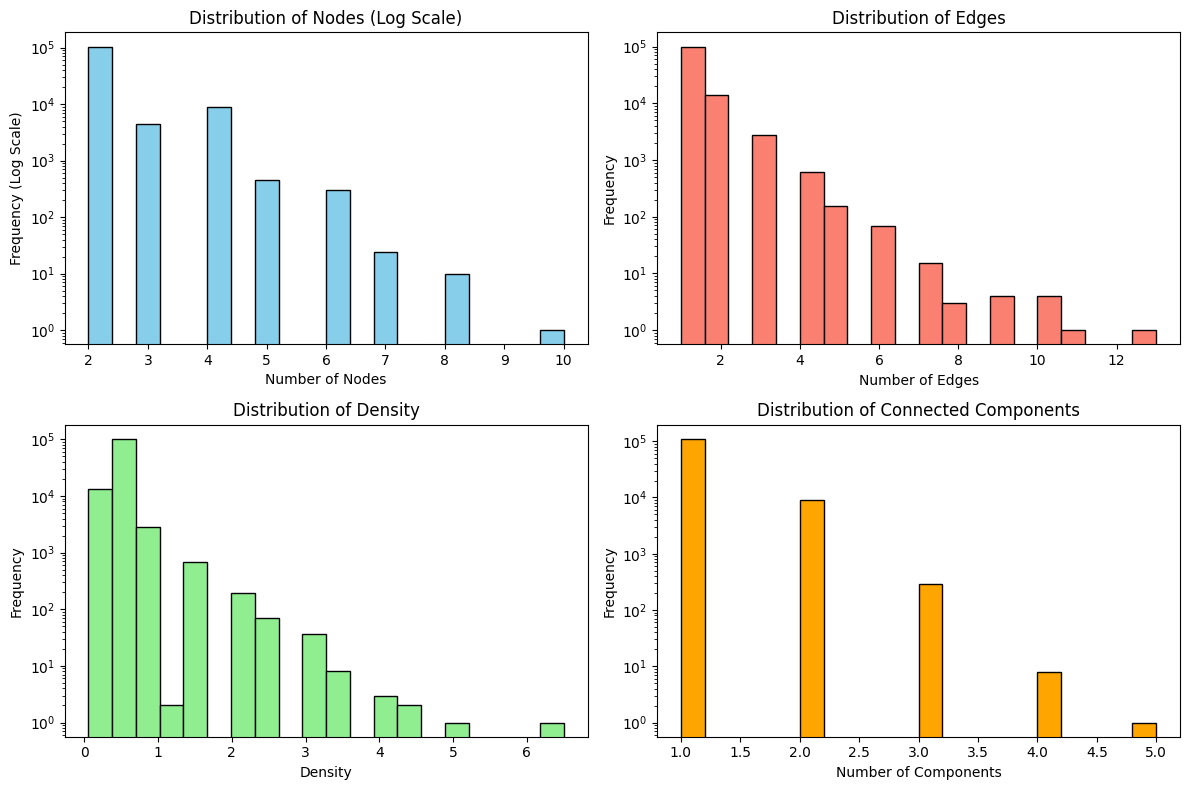

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

def analyze_graphs(graphs):
    num_nodes = []
    num_edges = []
    densities = []
    num_components = []

    for graph in graphs:
        num_nodes.append(graph.number_of_nodes())
        num_edges.append(graph.number_of_edges())
        densities.append(nx.density(graph))
        if nx.is_directed(graph):
            num_components.append(nx.number_weakly_connected_components(graph))
        else:
            num_components.append(nx.number_connected_components(graph))

    # Print summary statistics
    print("Statistics Summary:")
    print(f"Number of Graphs: {len(graphs)}")
    print(f"Average Number of Nodes: {sum(num_nodes) / len(graphs):.2f}")
    print(f"Average Number of Edges: {sum(num_edges) / len(graphs):.2f}")
    print(f"Average Density: {sum(densities) / len(graphs):.4f}")
    print(f"Average Number of Components: {sum(num_components) / len(graphs):.2f}")

    # Plot distributions
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.hist(num_nodes, bins=20, color='skyblue', edgecolor='black', log=True)
    plt.xlabel("Number of Nodes")
    plt.ylabel("Frequency (Log Scale)")
    plt.title("Distribution of Nodes (Log Scale)")

    plt.subplot(2, 2, 2)
    plt.hist(num_edges, bins=20, color='salmon', edgecolor='black', log=True)
    plt.xlabel("Number of Edges")
    plt.ylabel("Frequency")
    plt.title("Distribution of Edges")

    plt.subplot(2, 2, 3)
    plt.hist(densities, bins=20, color='lightgreen', edgecolor='black', log=True)
    plt.xlabel("Density")
    plt.ylabel("Frequency")
    plt.title("Distribution of Density")

    plt.subplot(2, 2, 4)
    plt.hist(num_components, bins=20, color='orange', edgecolor='black', log=True)
    plt.xlabel("Number of Components")
    plt.ylabel("Frequency")
    plt.title("Distribution of Connected Components")

    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `graph_list` is your list of NetworkX graphs
# analyze_graphs(graph_list)

analyze_graphs(graphs)

In [13]:
if flow_graph:
	y = df[dataset.label_col]
 
	if sort_timestamp:
		X_train, X_test, y_train, y_test = train_test_split(
			df, y, test_size=0.3)
	else:
		X_train, X_test, y_train, y_test = train_test_split(
			df, y, test_size=0.3, random_state=13, stratify=y)

	del df

	print(f"==>> X_train.shape: {X_train.shape}")
	print(f"==>> X_train.shape: {X_test.shape}")

	scaler = StandardScaler()

	X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])
	X_train['h'] = X_train[ cols_to_norm ].values.tolist()

	X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])
	X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [14]:
if flow_graph:
    G = nx.from_pandas_edgelist(X_train, dataset.src_ip_col, dataset.dst_ip_col, ['h',dataset.label_col], create_using=nx.MultiDiGraph())
    # get netowrk properties
    graph_measures = calculate_graph_measures(G, "datasets/" + name + "/training_graph_measures.json", verbose=True)
    print(f"==>> graph_measures: {graph_measures}")

    graph_measures = calculate_graph_measures(nx.DiGraph(G), "datasets/" + name + "/training_graph_simple_measures.json", verbose=True)
    print(f"==>> graph_measures: {graph_measures}")

    with open("datasets/" + name + "/training_graph.pkl", "wb") as f:
        pickle.dump(G, f)

In [15]:
if flow_graph:
    G_test = nx.from_pandas_edgelist(X_test, dataset.src_ip_col, dataset.dst_ip_col, ['h',dataset.label_col],create_using=nx.MultiDiGraph())
    
    graph_measures = calculate_graph_measures(G_test, "datasets/" + name + "/testing_graph_measures.json", verbose=True)
    print(f"==>> graph_measures: {graph_measures}")
    
    graph_measures = calculate_graph_measures(nx.DiGraph(G_test), "datasets/" + name + "/testing_graph_simple_measures.json", verbose=True)
    print(f"==>> graph_measures: {graph_measures}")
    
    with open("datasets/" + name + "/testing_graph.pkl", "wb") as f:
        pickle.dump(G_test, f)

In [16]:
# if window_graph and line_graph:

#     create_weightless_window_graph(
#         df=X_test,
#         src_ip_col=dataset.src_ip_col,
#         dst_ip_col=dataset.dst_ip_col,
#         window_size=window_size,
#         line_graph=True,
#         folder_path="datasets/" + name + "/line_graph/testing",
#         file_type="pkl")

In [17]:
# nx.write_gexf(G_test, "datasets/cic_ton_iot/testing_graph.gexf")